Linear Regression
=================
1. Problem setup
---------------

Let $f(x)$ be the __unknown__ target function we wish to learn, and let $D = \{(x_1, y_1), (x_2, y_2), .., (x_N, y_N)\}$ be the set of input-output examples we have.
We want to use machine learning to find a hypothesis $g$ that approximates the real target function $f$.

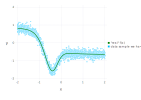

In [1]:
using Gadfly

NUMPOINTS = 2000;
x_train = 4*(rand(NUMPOINTS)-0.5);
F_x = 1.8*tanh(3.2*x_train + 0.8)- 2.5*tanh(2.1*x_train + 1.2)-0.2*tanh(0.1*x_train - 0.5)
noise = 0.2*std(F_x)
y_train =  F_x + noise*randn(size(x_train))

plot(layer(x=x_train, y=F_x, Geom.line, Theme(line_width=1.5pt, default_color = colorant"green")), 
layer(x=x_train, y=y_train, Geom.point, Theme(default_point_size=1.5pt, default_color = colorant"deepskyblue")),
Guide.manual_color_key("", ["\"real\" f(x)", "data sample we have"], ["green", "deepskyblue"]))

It is important to note that the data we have does not represent a deterministic function. Instead, it is a noisy target function formalized as a distribution that comes from adding noise to the "real" function $f$. In other words, we have an _unknown_ distribution $P(x,y)$ that generates each point $(x_N,y_N)$, and __we now want to find a hypothesis g that minimizes the error between $g(x)$ and $y$ with respect to that distribution__. 

2. Finding $g$
--------------
The linear regression algorithm is based on __minimizing the squared error between out hypothesis $h(x)$ and $y$__:

$$E_{out}(h) = E [(h(x) - y)^2]$$

where the expected value is taken with respect to the joint probability distribution $P(x, y)$. Since the distribution $P(x,y)$ is unknown, $E_{out}$ cannot be computed. So we resort to the in-sample error:

$$E_{in}(h) = \frac{1}{N} \sum_{n=1}^{N} (h(x_n) - y_n)^2 \tag{1}$$

In linear regression, h takes the form of a linear combination of the components of x. That is,
$$h(x) = \sum_{i=0}^{d} (w_i x_i)= \mathbf{w^T x} $$

We now have,
$$E_{in}(h) = \frac{1}{N} \sum_{n=1}^{N}(\mathbf{w^T x_n} - y_n)^2 \tag{2}$$

$$ = \frac{1}{N} \lVert \mathbf{Xw - y} \rVert^2 $$

$$ = \frac{1}{N} (\mathbf{w^TX^TXw -2w^TX^Ty + y^Ty}) \tag{3}$$

Then the linear regression algorithm is derived by minimizing $E_{in}(\mathbf{w})$ over all possible $\mathbf{w} \in \mathbb{R}^{d+1}$.
We can find the $\mathbf{w}$ that minimizes $E_{in}(\mathbf{w})$ by requiring that the gradient of $E_{in}$ with respect to $\mathbf{w}$ is the zero vector, i.e., $\nabla E_{in}(\mathbf{w}) = 0$.
The gradient is a column vector whose $i$th component is $[\nabla E_{in}(\mathbf{w})]_i = \frac{\delta}{\delta w_i}E_{in}(\mathbf{w})$. To obtain the gradient of $E_{in}$, we take the gradient of each term in (3):

$$ \nabla E_{in}(w) = \frac{2}{N}\mathbf{(X^TXw - X^Ty)} $$

For $\nabla E_{in}(w)$ to be 0, we should find $\mathbf{w}$ that satisfies:

$$ \mathbf{X^TXw} = \mathbf{X^Ty} $$

If $\mathbf{X^T X}$ is invertible, then $\mathbf{w = X^\dagger y}$, where $\mathbf{X^\dagger = (X^T X)}^{-1} \mathbf{X^T}$ is the __psuedo-inverse__ of $\mathbf{X}$. The resulting $\mathbf{w}$ will be the uniqie optimal solution.
If, however, $\mathbf{X^T X}$ is not invertible, a pseudo-inverse can still be define, but the solution will not be unique.
In practice, $\mathbf{X^T X}$ is invertible in most cases.

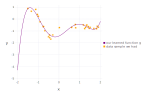

In [2]:
using CurveFit
using Polynomials

N = 30
xtest = 4*(rand(N)-0.5)
ytest = 1.8*tanh(3.2*xtest + 0.8)- 2.5*tanh(2.1*xtest + 1.2)-0.2*tanh(0.1*xtest - 0.5) + noise*randn(size(xtest))

X = [ones(N); xtest; xtest.^2; xtest.^3; xtest.^4; xtest.^5]'
w = pinv(X) * ytest'
ynew = X * w

p = poly_fit(xtest, ytest, 5);

xi=-2:0.01:2

plot(layer(x=xi, y=polyval(Poly(p), xi), Geom.line, Theme( default_color=colorant"purple")),
layer(x=xtest, y=ynew, Geom.point, Theme( default_color=colorant"orange")),

Guide.manual_color_key("", ["our learned function g(x)", "data sample we had"], ["purple", "orange"]))

3. In-sample error
------------------
We now wish to calculate the in-sample error $E_{in}$ to measure how good is our learned function $g$ at predicting the data distribution we had:

$$E_{in}(g) = \frac{1}{N} \sum_{n=1}^{N} (g(x_n) - y_n)^2 $$


In [3]:
E_in = mean((polyval(Poly(p), xtest) - ytest).^2)

0.03934637445863915

So our training model has an $E_{in} \approx 0.56$. Not too bad.  
Let us now plot the solution hypothesis *(our learned function $g$)* next to the data sample distribution we had. The in-sample error is represented as the vertical red lines that measure the distance between a point $(x_n, y_n)$ and $(x_n, g(x_n))$ 

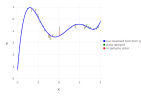

In [4]:
y = (ytest + polyval(Poly(p), xtest))./2
ymins = min(ytest, polyval(Poly(p), xtest))
ymaxs = max(ytest, polyval(Poly(p), xtest))

plot(layer(x=x_train, y=polyval(Poly(p), x_train), Geom.line, Theme(line_width = 1.5pt, default_color = colorant"blue")),
     layer(x=xtest, y=ytest, Geom.point, Theme( default_point_size=1.5pt, default_color = colorant"green")),
     layer(x=xtest, y=y, ymin=ymins, ymax=ymaxs, Geom.point, Geom.errorbar, Theme(line_width = 0.8pt, default_point_size=0pt, default_color = colorant"red", errorbar_cap_length = 0.01pt )),
     Guide.manual_color_key("", ["our learned function g(x)", "data sample", "in-sample error"], ["blue", "green", "red"]))


4. Generalization issues: out-of-sample error
---------------------------------------------

In [5]:
E_out = mean((polyval(Poly(p), x_train) - y_train).^2)

0.7557201043159917

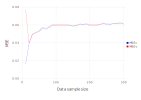

In [41]:
MSEc = zeros(30)
MSEv = zeros(30)

for j=1:30
    N = j * 10
    total_MSEc=0
    total_MSEv=0
    for i=1:100
        xtest = 4*(rand(N)-0.5)
        ytest = 1.8*tanh(3.2*xtest + 0.8)- 2.5*tanh(2.1*xtest + 1.2)-0.2*tanh(0.1*xtest - 0.5) + noise*randn(size(xtest))
    
        p = poly_fit(xtest, ytest, 5)
        err_emp = sum((polyval(Poly(p), xtest) - ytest).^2)
        err_gen = sum((polyval(Poly(p), x_train) - y_train).^2)
        total_MSEc = total_MSEc + err_emp/N
        total_MSEv = total_MSEc + err_gen/NUMPOINTS
    end
    MSEc[j] = total_MSEc/100
    MSEv[j] = total_MSEv/100
end

plot(
layer(x=10:10:300, y=MSEc, Geom.line, Theme(line_width=0.3pt, default_color=colorant"blue")),
layer(x=10:10:300, y=MSEv, Geom.line, Theme(line_width=0.3pt, default_color=colorant"red")),
Guide.manual_color_key("", ["MSEc", "MSEv"], ["blue", "red"]), Guide.xlabel("Data sample size"), Guide.ylabel("MSE"))

5. How many parameters should our hypthesis functions have?
-----------------------------------------------------------

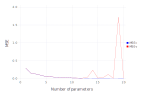

In [39]:
N = 50;
MSEc = zeros(20)
MSEv = zeros(20)

for j=1:20
    total_MSEc=0
    total_MSEv=0
    for i=1:100
        xtest = 4*(rand(N)-0.5)
        ytest = 1.8*tanh(3.2*xtest + 0.8)- 2.5*tanh(2.1*xtest + 1.2)-0.2*tanh(0.1*xtest - 0.5) + noise*randn(size(xtest))
    
        p = poly_fit(xtest, ytest, j)
        err_emp = sum((polyval(Poly(p), xtest) - ytest).^2)
        err_gen = sum((polyval(Poly(p), x_train) - y_train).^2)
        total_MSEc = total_MSEc + err_emp/N
        total_MSEv = total_MSEc + err_gen/NUMPOINTS
    end
    MSEc[j] = total_MSEc/100
    MSEv[j] = total_MSEv/100
end
plot(
layer(x=1:20, y=MSEc, Geom.line, Theme(line_width=0.3pt, default_color=colorant"blue")),
layer(x=1:20, y=MSEv, Geom.line, Theme(line_width=0.3pt, default_color=colorant"red")),
Guide.manual_color_key("", ["MSEc", "MSEv"], ["blue", "red"]), Guide.xlabel("Number of parameters"), Guide.ylabel("MSE"))